# WaveRNN - Faster Model - Fit Sine

In previous notebooks the model had an overly complicated forward pass. Since the groundtruth of the coarse sample is known in training, the gates for coarse and fine can all be done in one set of operations. Things have been simplified a good deal. However, the input projection still needs tidying up.

This results in a training speed up of around 30% with a batch size of one. And around 10% speed up with a batch size of 64. Inference speed is still around the same.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time, sys, math
import numpy as np
import torch
from torch.autograd import Variable 
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import wavfile
from utils import *

In [2]:
notebook_name = 'nb4'
sample_rate = 24000

In [3]:
def sine_wave(freq, length, sample_rate=sample_rate) : 
    return np.sin(np.arange(length) * 2 * math.pi * freq / sample_rate).astype(np.float32)

In [6]:
def encode_16bits(x) : 
    return np.clip(x * 2**15, -2**15, 2**15 - 1).astype(np.int16)

In [7]:
def split_signal(x) :
    encoded = encode_16bits(x)
    unsigned = encoded + 2**15
    coarse = unsigned // 256
    fine = unsigned % 256
    return coarse, fine

In [8]:
c, f = split_signal(signal)

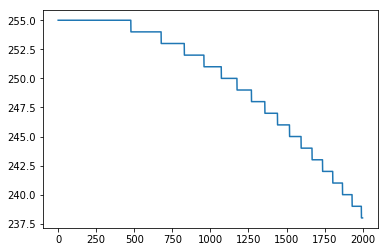

In [9]:
plt.plot(c[30000:32000])

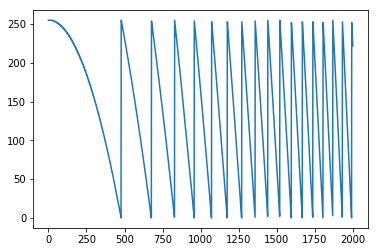

In [10]:
plt.plot(f[30000:32000])

In [11]:
c.max(), c.min(), f.max(), f.min()

(255, 0, 255, 0)

## New Model Class

In [18]:
class WaveRNN(nn.Module) :
    def __init__(self, hidden_size=896, quantisation=256) :
        super(WaveRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.split_size = hidden_size // 2
        
        # The main hidden state matmul
        self.R = nn.Linear(self.hidden_size, 3 * self.hidden_size, bias=False)
        
        # Output fc layers
        self.O1 = nn.Linear(self.split_size, self.split_size)
        self.O2 = nn.Linear(self.split_size, quantisation)
        self.O3 = nn.Linear(self.split_size, self.split_size)
        self.O4 = nn.Linear(self.split_size, quantisation)
        
        # Input fc layers
        self.I_coarse = nn.Linear(2, 3 * self.split_size, bias=False)
        self.I_fine = nn.Linear(3, 3 * self.split_size, bias=False)

        # biases for the gates
        self.bias_u = nn.Parameter(torch.zeros(self.hidden_size))
        self.bias_r = nn.Parameter(torch.zeros(self.hidden_size))
        self.bias_e = nn.Parameter(torch.zeros(self.hidden_size))
        
        # display num params
        self.print_stats()

        
    def forward(self, prev_y, prev_hidden, current_coarse) :
        
        # Main matmul - the projection is split 3 ways
        R_hidden = self.R(prev_hidden)
        R_u, R_r, R_e, = torch.split(R_hidden, self.hidden_size, dim=1)
        
        # Project the prev input 
        coarse_input_proj = self.I_coarse(prev_y)
        I_coarse_u, I_coarse_r, I_coarse_e = \
            torch.split(coarse_input_proj, self.split_size, dim=1)
        
        # Project the prev input and current coarse sample
        fine_input = torch.cat([prev_y, current_coarse], dim=1)
        fine_input_proj = self.I_fine(fine_input)
        I_fine_u, I_fine_r, I_fine_e = \
            torch.split(fine_input_proj, self.split_size, dim=1)
        
        # concatenate for the gates
        # TODO: Simplify all of this business 
        I_u = torch.cat([I_coarse_u, I_fine_u], dim=1)
        I_r = torch.cat([I_coarse_r, I_fine_r], dim=1)
        I_e = torch.cat([I_coarse_e, I_fine_e], dim=1)
        
        # Compute all gates for coarse and fine 
        u = F.sigmoid(R_u + I_u + self.bias_u)
        r = F.sigmoid(R_r + I_r + self.bias_r)
        e = F.tanh(r * R_e + I_e + self.bias_e)
        hidden = u * prev_hidden + (1. - u) * e
        
        # Split the hidden state
        hidden_coarse, hidden_fine = torch.split(hidden, self.split_size, dim=1)
        
        # Compute outputs 
        out_coarse = self.O2(F.relu(self.O1(hidden_coarse)))
        out_fine = self.O4(F.relu(self.O3(hidden_fine)))

        return out_coarse, out_fine, hidden
    
        
    def generate(self, seq_len) :
        
        # First split up the biases for the gates 
        b_coarse_u, b_fine_u = torch.split(self.bias_u, self.split_size)
        b_coarse_r, b_fine_r = torch.split(self.bias_r, self.split_size)
        b_coarse_e, b_fine_e = torch.split(self.bias_e, self.split_size)
        
        # Lists for the two output seqs
        c_outputs, f_outputs = [], []
        
        # Some initial inputs
        out_coarse = Variable(torch.LongTensor([0])).cuda()
        out_fine = Variable(torch.LongTensor([0])).cuda()
        
        # We'll meed a hidden state
        hidden = self.init_hidden()
        
        # Need a clock for display
        start = time.time()
        
        # Loop for generation
        for i in range(seq_len) :
            
            # Split into two hidden states
            hidden_coarse, hidden_fine = \
                torch.split(hidden, self.split_size, dim=1)
            
            # Scale and concat previous predictions
            out_coarse = out_coarse.unsqueeze(0).float() / 127.5 - 1.
            out_fine = out_fine.unsqueeze(0).float() / 127.5 - 1.
            prev_outputs = torch.cat([out_coarse, out_fine], dim=1)
            
            # Project input 
            coarse_input_proj = self.I_coarse(prev_outputs)
            I_coarse_u, I_coarse_r, I_coarse_e = \
                torch.split(coarse_input_proj, self.split_size, dim=1)
            
            # Project hidden state and split 6 ways
            R_hidden = self.R(hidden)
            R_coarse_u , R_fine_u, \
            R_coarse_r, R_fine_r, \
            R_coarse_e, R_fine_e = torch.split(R_hidden, self.split_size, dim=1)
        
            # Compute the coarse gates
            u = F.sigmoid(R_coarse_u + I_coarse_u + b_coarse_u)
            r = F.sigmoid(R_coarse_r + I_coarse_r + b_coarse_r)
            e = F.tanh(r * R_coarse_e + I_coarse_e + b_coarse_e)
            hidden_coarse = u * hidden_coarse + (1. - u) * e
            
            # Compute the coarse output
            out_coarse = self.O2(F.relu(self.O1(hidden_coarse)))
            posterior = F.softmax(out_coarse, dim=1).view(-1)
            distrib = torch.distributions.Categorical(posterior)
            out_coarse = distrib.sample()
            c_outputs.append(out_coarse)
            
            # Project the [prev outputs and predicted coarse sample]
            coarse_pred = out_coarse.float() / 127.5 - 1.
            fine_input = torch.cat([prev_outputs, coarse_pred.unsqueeze(0)], dim=1)
            fine_input_proj = self.I_fine(fine_input)
            I_fine_u, I_fine_r, I_fine_e = \
                torch.split(fine_input_proj, self.split_size, dim=1)
            
            # Compute the fine gates
            u = F.sigmoid(R_fine_u + I_fine_u + b_fine_u)
            r = F.sigmoid(R_fine_r + I_fine_r + b_fine_r)
            e = F.tanh(r * R_fine_e + I_fine_e + b_fine_e)
            hidden_fine = u * hidden_fine + (1. - u) * e
        
            # Compute the fine output
            out_fine = self.O4(F.relu(self.O3(hidden_fine)))
            posterior = F.softmax(out_fine, dim=1).view(-1)
            distrib = torch.distributions.Categorical(posterior)
            out_fine = distrib.sample()
            f_outputs.append(out_fine)
    
            # Put the hidden state back together
            hidden = torch.cat([hidden_coarse, hidden_fine], dim=1)
            
            # Display progress
            speed = (i + 1) / (time.time() - start)
            display('Gen: %i/%i -- Speed: %i',  (i + 1, seq_len, speed))
        
        coarse = torch.stack(c_outputs).squeeze(1).cpu().data.numpy()
        fine = torch.stack(f_outputs).squeeze(1).cpu().data.numpy()        
        output = combine_signal(coarse, fine)
        
        return output, coarse, fine
        
             
    def init_hidden(self, batch_size=1) :
        return (Variable(torch.zeros(batch_size, self.hidden_size)).cuda())
    
    
    def print_stats(self) :
        parameters = filter(lambda p: p.requires_grad, self.parameters())
        parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
        print('Trainable Parameters: %.3f million' % parameters)

In [19]:
model = WaveRNN().cuda()

Trainable Parameters: 3.050 million


### Train Model

In [24]:
x = sine_wave(freq=500, length=sample_rate * 30)
coarse_classes, fine_classes = split_signal(x)
coarse_classes = np.reshape(coarse_classes, (1, -1))
fine_classes = np.reshape(fine_classes, (1, -1))

In [25]:
def train(model, optimizer, num_steps, seq_len=960) :
    
    start = time.time()
    running_loss = 0
    
    for step in range(num_steps) :
        
        loss = 0
        hidden = model.init_hidden()
        optimizer.zero_grad()
        rand_idx = np.random.randint(0, coarse_classes.shape[1] - seq_len - 1)
        
        for i in range(seq_len) :
            
            j = rand_idx + i
            
            x_coarse = coarse_classes[:, j:j + 1]
            x_fine = fine_classes[:, j:j + 1]
            x_input = np.concatenate([x_coarse, x_fine], axis=1)
            x_input = x_input / 127.5 - 1.
            x_input = Variable(torch.FloatTensor(x_input)).cuda()
            
            y_coarse = coarse_classes[:, j + 1]
            y_fine = fine_classes[:, j + 1]
            y_coarse = Variable(torch.LongTensor(y_coarse)).cuda()
            y_fine = Variable(torch.LongTensor(y_fine)).cuda()
            
            current_coarse = y_coarse.float() / 127.5 - 1.
            current_coarse = current_coarse.unsqueeze(-1)
            
            out_coarse, out_fine, hidden = model(x_input, hidden, current_coarse)
            
            loss_coarse = F.cross_entropy(out_coarse, y_coarse)
            loss_fine = F.cross_entropy(out_fine, y_fine)
            loss += (loss_coarse + loss_fine)
        
        running_loss += (loss.data[0] / seq_len)
        loss.backward()
        optimizer.step()
        
        speed = (step + 1) / (time.time() - start)
        
        sys.stdout.write('\rStep: %i/%i --- NLL: %.2f --- Speed: %.3f batches/second ' % 
                        (step + 1, num_steps, running_loss / (step + 1), speed))    

In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [27]:
train(model, optimizer, num_steps=500)

Step: 500/500 --- NLL: 0.37 --- Speed: 0.854 batches/second 

### Generate

In [35]:
output, c, f = model.generate(5000)

Gen: 5000/5000 -- Speed: 1121

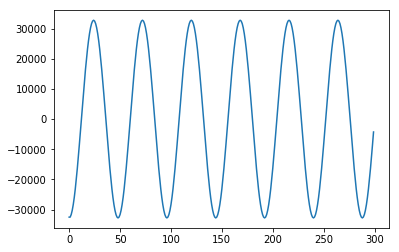

In [41]:
plt.plot(output[:300])

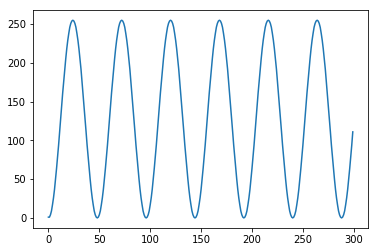

In [42]:
plt.plot(c[:300])

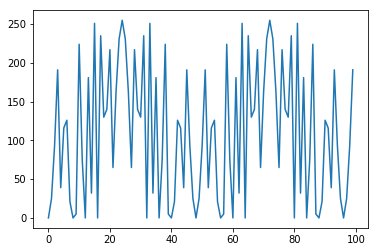

In [43]:
plt.plot(f[:100])

And compare the fine output to the ground truth...

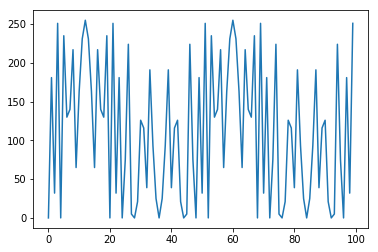

In [44]:
plt.plot(fine_classes[0, :100])

## Compare Training Speed with Old Model

In [57]:
class WaveRNN_old(nn.Module) :
    def __init__(self, hidden_size=896, quantisation=256) :
        super(WaveRNN_old, self).__init__()
        self.hidden_size = hidden_size
        self.split_size = hidden_size // 2
        # This one's for the big hidden state matmul
        self.R = nn.Linear(self.hidden_size, 3 * self.hidden_size, bias=False)
        # Output fc layers
        self.O1 = nn.Linear(self.split_size, self.split_size)
        self.O2 = nn.Linear(self.split_size, quantisation)
        self.O3 = nn.Linear(self.split_size, self.split_size)
        self.O4 = nn.Linear(self.split_size, quantisation)
        # Paper mentions masked matrix. Is this equivalent?
        self.I_coarse = nn.Linear(2, 3 * self.split_size, bias=False)
        self.I_fine = nn.Linear(3, 3 * self.split_size, bias=False)
        # May as well explicitly define all biases here
        # to avoid unnecessary splits in the forward pass
        self.bias_coarse_u = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_coarse_r = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_coarse_e = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_fine_u = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_fine_r = Variable(torch.zeros(self.split_size)).cuda()
        self.bias_fine_e = Variable(torch.zeros(self.split_size)).cuda()
        # display num of params
        self.print_stats()

    
    def forward(self, prev_x, prev_hidden, current_coarse=None, generate=False) :
        # Main matmul - the projection is split 6 ways
        # for the coarse/fine gates
        R_hidden = self.R(prev_hidden)
        R_coarse_u, R_coarse_r, R_coarse_e, \
        R_fine_u, R_fine_r, R_fine_e = torch.split(R_hidden, self.split_size, dim=1)
        
        # Project the input and split for coarse gates
        coarse_input_proj = self.I_coarse(prev_x)
        I_coarse_u, I_coarse_r, I_coarse_e = \
            torch.split(coarse_input_proj, self.split_size, dim=1)
        
        # The hidden state needs to be split up too 
        hidden_coarse, hidden_fine = torch.split(prev_hidden, self.split_size, dim=1)
    
        # Compute the first round of gates: coarse
        u_coarse = F.sigmoid(R_coarse_u + I_coarse_u + self.bias_coarse_u)
        r_coarse = F.sigmoid(R_coarse_r + I_coarse_r + self.bias_coarse_r)
        e_coarse = F.tanh(r_coarse * R_coarse_e + I_coarse_e + self.bias_coarse_e)
        hidden_coarse = u_coarse * hidden_coarse + (1. - u_coarse) * e_coarse
        
        # Compute outputs for coarse 
        out_coarse = self.O2(F.relu(self.O1(hidden_coarse)))
        
        # If generating pick a coarse sample 
        if generate :
            # TODO: sample it on the gpu
            probabilities = F.softmax(out_coarse, dim=1).view(-1).data.cpu().numpy()
            out_coarse = int(np.random.choice(np.arange(256), p=probabilities))
            # Sample needs to be concatenated with the prev_x below
            current_coarse = Variable(torch.FloatTensor([[out_coarse]])).cuda()
            current_coarse = current_coarse / 127.5 - 1.

        # concatenate the prev c/f samples with the coarse 
        # predicted (while generating) or ground truth(while training) 
        fine_input = torch.cat([prev_x, current_coarse], dim=1)
        fine_input_proj = self.I_fine(fine_input)
        I_fine_u, I_fine_r, I_fine_e = \
            torch.split(fine_input_proj, self.split_size, dim=1)
        
        # Compute the second round of gates: fine
        # TODO: in training all c/f gates can be computed at the same time right?
        u_fine = F.sigmoid(R_fine_u + I_fine_u + self.bias_fine_u)
        r_fine = F.sigmoid(R_fine_r + I_fine_r + self.bias_fine_r)
        e_fine = F.tanh(r_fine * R_fine_e + I_fine_e + self.bias_fine_e)
        hidden_fine = u_fine * hidden_fine + (1. - u_fine) * e_fine
        
        # Compute outputs for fine
        out_fine = self.O4(F.relu(self.O3(hidden_fine)))
        
        # If generating pick a fine sample
        if generate :
            probabilities = F.softmax(out_fine, dim=1).view(-1).data.cpu().numpy()
            out_fine = int(np.random.choice(np.arange(256), p=probabilities))
        
        # put the hidden state back together
        hidden = torch.cat([hidden_coarse, hidden_fine], dim=1)
        
        return out_coarse, out_fine, hidden
    
    
    def generate(self, seq_len) :
        
        start = time.time()
        hidden = self.init_hidden()
        
        # Append outputs to these lists 
        c_outputs = []
        f_outputs = []
        
        # Some initial values to start
        coarse_out = 0
        fine_out = 0
        
        for i in range(seq_len) :
            
            # wrap the last inputs as a Variable
            input = Variable(torch.FloatTensor\
                             ([[coarse_out, fine_out]]), volatile=True).cuda()
            
            # Feed to the model and save outputs
            coarse_out, fine_out, hidden = self.forward(input, hidden, generate=True)
            c_outputs.append(coarse_out)
            f_outputs.append(fine_out)
            
            # Scale down the outputs
            coarse_out = coarse_out / 127.5 - 1.
            fine_out = fine_out / 127.5 - 1.
            
            # Display stats
            gen_speed = (i + 1) / (time.time() - start)
            sys.stdout.write('\r%i/%i @%i samples/sec' % (i + 1, seq_len, gen_speed))

        coarse_seq = np.array(c_outputs)
        fine_seq = np.array(f_outputs)
        
        return combine_signal(coarse_seq, fine_seq), coarse_seq, fine_seq
        
        
    def init_hidden(self, batch_size=1) :
        return (Variable(torch.zeros(batch_size, self.hidden_size)).cuda())
    
    
    def print_stats(self) :
        parameters = filter(lambda p: p.requires_grad, self.parameters())
        parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
        print('Trainable Parameters: %.3f million' % parameters)

In [58]:
old_model = WaveRNN_old().cuda()

Trainable Parameters: 3.047 million


In [59]:
train(old_model, optimizer, num_steps=50)

Step: 50/50 --- NLL: 11.07 --- Speed: 0.654 batches/second 

In [60]:
speed_up = (.854 - .654) / .654 * 100

In [61]:
speed_up

30.581039755351675

Well that's a nice 30% speed up on the old model. This is at a batch size of one so I'd expect diminishing returns as the batch size goes up. Still though, I'll take it. 